In [237]:
import numpy as np
import seaborn as sns
from tqdm import tqdm

# Parameters

In [238]:
initial_cases = 2 # 1000
imported_cases_per_step = 2

discount = 0.9
num_population = 100 # 100000

# Cost of setting R
R_0 = 2.5
power = 1.0
scale_factor = 1000 # 1e10

# Cost of N (number of cases)
hospital_capacity = 30 # 20000
cost_per_hospital_visit = 10 # 50000
cost_per_hospital_deprived_case = 20 # 500000

In [239]:
def cost_of_r(r, power=power, scale_factor=scale_factor):
    baseline = 1/(R_0 ** power)
    if r >= R_0:
        return 0
    else:
        return (1/(r**power) - baseline) * scale_factor

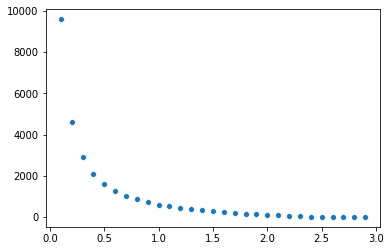

In [240]:
rs = np.arange(0.1, 3.0, 0.1)
costs_of_r = [cost_of_r(r) for r in rs]
sns.scatterplot(x=rs, y=costs_of_r)

In [241]:
def cost_of_n(n, slope1=cost_per_hospital_visit, slope2=cost_per_hospital_deprived_case, capacity=hospital_capacity):
    if n <= 0:
        return 0
    elif n <= capacity:
        return n * slope1
    else:
        return capacity * slope1 + (n - capacity) * slope2

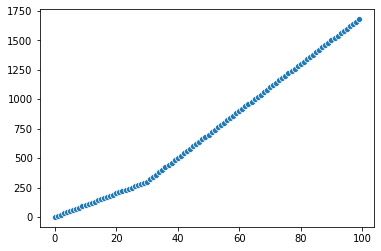

In [242]:
ns = list(range(num_population))
     #sum([list(range(100*i, 100*(i+1), i+1)) for i in range(10)], []) + \
     # sum([list(range(1000*i, 1000*(i+1), (i+1)*10)) for i in range(1, 10)], []) + \
     # sum([list(range(10000*i, 10000*(i+1), (i+1)*100)) for i in range(1, 10)], [])
costs_of_n = [cost_of_n(n) for n in ns]
sns.scatterplot(x=ns, y=costs_of_n)

In [243]:
np.random.default_rng().poisson(lam=100)

105

In [244]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [249]:
def step(state, action):
    # state: number of current cases (discretized)
    # action: value of R_effective to set (discretized)
    # return: new_state, reward
    
    r_effective = action
    current_cases = state
    
    fraction_susceptible = (num_population - current_cases) / num_population
    expected_new_cases = (current_cases * r_effective + imported_cases_per_step) * fraction_susceptible

    # TODO: change to negative binomial; look up constant in literature for COVID
    new_state = np.random.default_rng().poisson(lam=expected_new_cases)
    # np.random.negative_binomial
    reward = -cost_of_n(new_state) - cost_of_r(r_effective)
    
    new_state = find_nearest(ns, new_state)  # discretized case count
    
    return new_state, reward

In [250]:
np.random.negative_binomial(5, 0.5)

2

## Initial Conditions

## Value Iteration

In [251]:
def select_action(state, value_table):
    rewards = {}
    for action in rs:
        new_state, reward = step(state, action) # sample a new state
        future_reward = value_table[new_state]
        value = reward + discount * future_reward
        rewards[action] = value
    argmax_reward, max_reward = max(rewards.items(), key=lambda x: x[1])
    return argmax_reward, max_reward # action, lifetime value of taking this action

In [252]:
value_table = {n: 0 for n in ns}
# current_state = initial_cases
print(value_table)
for i in tqdm(range(20)):
    new_value_table = {}
    for state in value_table:
        best_action, max_reward = select_action(state, value_table)
        new_value_table[state] = max_reward
    value_table = new_value_table

  0%|          | 0/20 [00:00<?, ?it/s]

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0}


100%|██████████| 20/20 [00:04<00:00,  4.03it/s]


In [253]:
'%E' % min(value_table.items(), key=lambda x: x[1])[1]

'-2.940772E+03'

In [254]:
'%E' % value_table[ns[-1]]

'-5.265738E+02'

In [255]:
'%E' % value_table[ns[0]]

'-5.265738E+02'

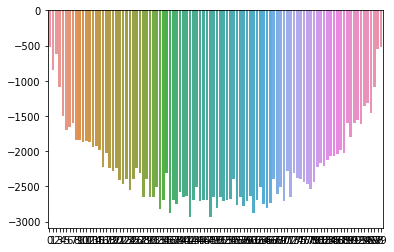

In [256]:
sns.barplot(list(value_table.keys()),
            list(value_table.values()))

In [257]:
# Roll-Out Using Optimal Policy

current_state = initial_cases
total_reward = 0
current_discount = 1

action_history = []
state_history = [current_state]

for i in tqdm(range(10)):
    action, expected_total_reward = select_action(current_state, value_table)
    new_state, reward = step(current_state, action)
    total_reward += reward * discount
    
    current_state = new_state
    current_discount *= discount
    
    action_history.append(action)
    state_history.append(current_state)

100%|██████████| 10/10 [00:00<00:00, 261.68it/s]


In [258]:
total_reward

-4359.656067314029

In [259]:
state_history

[2, 4, 6, 16, 29, 26, 38, 18, 42, 21, 32]

In [260]:
action_history

[2.3000000000000003,
 2.8000000000000003,
 2.4000000000000004,
 1.9000000000000001,
 1.0,
 1.7000000000000002,
 1.0,
 2.2,
 1.3000000000000003,
 1.4000000000000001]

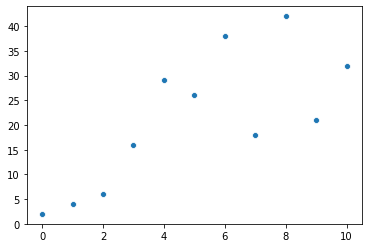

In [261]:
sns.scatterplot(x=list(range(len(state_history))), y=state_history)

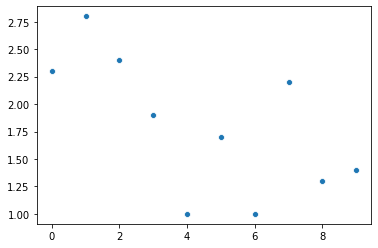

In [262]:
sns.scatterplot(x=list(range(len(action_history))), y=action_history)